In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset,Subset
from torch.utils.data import random_split
import torch.nn.init as init
import torch.nn.functional as F

import json
import h5py
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
# from adopt import ADOPT
from sklearn.model_selection import train_test_split
import math

from einops import rearrange
from einops.layers.torch import Rearrange
import random


In [2]:
def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True)

In [3]:
class TemporalConv1D(nn.Module):
    """Simple temporal conv block for feature alignment"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,dp=0.0):
        super(TemporalConv1D, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                               padding=padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dp)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

In [4]:
######## cross attention #######

class CrossAttention(nn.Module):
    """Cross-attention between two feature streams"""
    def __init__(self, embed_dim, num_heads=16,dp=0.0):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,
                                                    dropout=dp, batch_first=True)

    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

In [5]:
######## MHSA ########
class MHSA(nn.Module):
    """Multi-Head Self Attention"""
    def __init__(self, embed_dim, num_heads=16,dp=0.0):
        super(MHSA, self).__init__()
        self.mhsa = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,dropout=dp, 
                                          batch_first=True)

    def forward(self, x):
        attn_output, _ = self.mhsa(x, x, x)
        return attn_output

In [6]:
######## Fusion model v4 ########

class FusionModel(nn.Module):

    def __init__(self, swin_feat_dim=(50, 1024)):
        
        self.swin_feat_dim = swin_feat_dim
        super(FusionModel, self).__init__()

        self.temporal_conv_swin = TemporalConv1D(self.swin_feat_dim[-1], 256, kernel_size=3, stride=1, 
                                                 padding =1,dp=0) 
        self.mhsa = MHSA(embed_dim =256  ,num_heads = 8 , dp = 0 )

        self.globalpool = nn.Sequential(
            nn.AdaptiveAvgPool1d(1)  # Global temporal pooling
        )

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        
        # Apply custom weight initialization
        self.apply(self.kaiming_initialize)
    
    def kaiming_initialize(self,layer):
        """Apply Kaiming initialization for all relevant layers, including MultiHeadAttention."""
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.MultiheadAttention):
            # Initialize in_proj_weight and in_proj_bias
            nn.init.kaiming_normal_(layer.in_proj_weight, mode='fan_in', nonlinearity='relu')
            if layer.in_proj_bias is not None:
                nn.init.constant_(layer.in_proj_bias, 0)
            # Initialize out_proj weight and bias
            nn.init.kaiming_normal_(layer.out_proj.weight, mode='fan_in', nonlinearity='relu')
            if layer.out_proj.bias is not None:
                nn.init.constant_(layer.out_proj.bias, 0)

    

    def forward(self, swin_features ):

        # swin_features (B,50,1024)
        swin_features = swin_features.permute(0,2,1) # (B,1024,50)
        swin_features = self.temporal_conv_swin ( swin_features).permute(0,2,1) # (B,256,50)
        swin_features = self.mhsa( swin_features ) # (B,50,256)
        swin_features = self.globalpool( swin_features.permute(0,2,1) ) # (B,256)
        swin_features  =swin_features.squeeze(-1)
        output = self.classifier(swin_features) # (B,1) 

        return output.squeeze(-1)

In [7]:
def load_data(swin_file_path,labels_file_path):
     
    swin_features = np.load(swin_file_path)
    labels = np.load(labels_file_path)
    
    return swin_features,labels

In [8]:
def dataloaders (swin_train,swin_val,swin_test,labels_train,labels_val,labels_test,
                 batch_size):
    # Convert numpy arrays to PyTorch tensors
    swin_train_tensor = torch.tensor(swin_train, dtype=torch.float32)
    swin_val_tensor = torch.tensor(swin_val, dtype=torch.float32)
    swin_test_tensor = torch.tensor(swin_test, dtype=torch.float32)

    labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
    labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
    labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(swin_train_tensor, labels_train_tensor)
    val_dataset = TensorDataset(swin_val_tensor, labels_val_tensor)
    test_dataset = TensorDataset(swin_test_tensor, labels_test_tensor)

    # Optional: Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader,val_loader,test_loader

In [9]:
def plot_graph(train_accuracies, train_losses, val_accuracies, val_losses, num_epochs):
    # import matplotlib.pyplot as plt

    epochs = range(1, num_epochs + 1)

    # Set figure size and reduce resolution via dpi
    fig, ax1 = plt.subplots(figsize=(7, 5), dpi=72)

    # Plot accuracy curves on the left y-axis
    ax1.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o', linestyle='-')
    ax1.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='s', linestyle='--')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a twin axis for the loss curves
    ax2 = ax1.twinx()
    ax2.plot(epochs, train_losses, label='Training Loss', color='red', marker='o', linestyle='-')
    ax2.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='s', linestyle='--')
    ax2.set_ylabel('Loss', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', ncol=2)

    plt.title('Training vs Validation Metrics')
    plt.tight_layout()
    plt.show()


In [10]:
def train(model,train_loader,val_loader,device,num_epochs,lr,batch_size,weight_decay):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    train_accuracies = []
    val_losses = []  
    val_accuracies = []

    for epoch in range(num_epochs) :
        model.train()

        running_loss = 0
        correct_train = 0
        total_train = 0

        for swin_features,labels in train_loader:
            swin_features = swin_features.to(device)
            labels = labels.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Make predictions for this batch      
            outputs = model(swin_features)
            
            # Compute the loss and its gradients
            loss = criterion(outputs, labels.float())
            loss.backward()

            # Adjust learning weights        
            optimizer.step()

            running_loss += loss.data.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply threshold for binary classification
            total_train += labels.size(0)
            correct_train += (predicted.view(-1) == labels.float()).sum().item()  # Ensure same shape

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        print(f'epoch [{epoch }/{num_epochs}], train_loss: {epoch_loss:.4f}, train_accuracy: {epoch_acc:.2f}%')
    
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()

        correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for swin_features, labels in val_loader:
                
                swin_features = swin_features.to(device)
                labels = labels.to(device)
                
                outputs = model(swin_features)
                loss = criterion(outputs, labels.float())

                running_val_loss += loss.data.item()

                predicted = (torch.sigmoid(outputs) > 0.5).float() 
                total_val += labels.size(0)
                correct_val += (predicted.view(-1) == labels.float()).sum().item()  
                
        val_acc = 100 * correct_val / total_val
        val_loss = running_val_loss / len(val_loader)

        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        print(f'validation_loss: {val_loss:.4f}, validation_accuracy: {val_acc:.2f}%')

        torch.cuda.empty_cache()    


    plot_graph( train_accuracies ,train_losses, val_accuracies ,val_losses, num_epochs )






In [11]:
# Hyperparameters
lr = 0.001
batch_size = 256
num_epochs = 15
seed = 42
weight_decay = 0.001

SwinData loaded (12299, 50, 1024)
labels loaded (12299,)
(9839, 50, 1024)
epoch [0/15], train_loss: 0.8145, train_accuracy: 65.88%
validation_loss: 0.5097, validation_accuracy: 75.12%
epoch [1/15], train_loss: 0.3783, train_accuracy: 82.06%
validation_loss: 0.4032, validation_accuracy: 80.24%
epoch [2/15], train_loss: 0.2927, train_accuracy: 86.35%
validation_loss: 0.3800, validation_accuracy: 82.76%
epoch [3/15], train_loss: 0.2319, train_accuracy: 89.72%
validation_loss: 0.3006, validation_accuracy: 86.75%
epoch [4/15], train_loss: 0.2240, train_accuracy: 90.28%
validation_loss: 0.3083, validation_accuracy: 85.37%
epoch [5/15], train_loss: 0.1898, train_accuracy: 91.36%
validation_loss: 0.4461, validation_accuracy: 84.15%
epoch [6/15], train_loss: 0.1955, train_accuracy: 91.45%
validation_loss: 0.2560, validation_accuracy: 89.59%
epoch [7/15], train_loss: 0.1453, train_accuracy: 93.38%
validation_loss: 0.2422, validation_accuracy: 91.14%
epoch [8/15], train_loss: 0.1438, train_accura

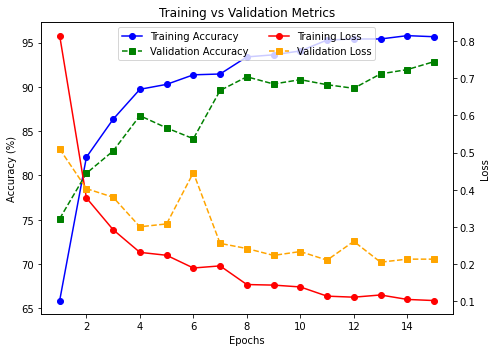

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Seeting the seed
set_seed( seed )

# Folders
swin_file = r"data_swin.npy"
labels_file = r"labels.npy"

# Loading the data 
swin_data,labels = load_data(swin_file,labels_file)
print( "SwinData loaded",swin_data.shape)
print( "labels loaded",labels.shape)
# Data splitting
swin_train, swin_temp, labels_train, labels_temp = train_test_split(swin_data, labels, test_size=0.2, stratify=labels, random_state=42)
swin_val, swin_test, labels_val, labels_test = train_test_split(swin_temp, labels_temp, test_size=0.5, stratify=labels_temp, random_state=42)
print( swin_train.shape)
# Dataloaders
train_loader,val_loader,test_loader = dataloaders(swin_train,swin_val,swin_test,
                                                  labels_train,labels_val,labels_test
                                                  ,batch_size)

# Setting up the model
model = FusionModel().to(device)

# Training the mdoel
train(model,train_loader,val_loader,device,num_epochs,lr,batch_size,weight_decay)

In [ ]:
# Testing the model 

model.eval()

correct_test = 0
total_test = 0

with torch.no_grad():
    for swin_features, labels in test_loader:
        
        swin_features = swin_features.to(device)
        labels = labels.to(device)
        
        outputs = model(swin_features)


        predicted = (torch.sigmoid(outputs) > 0.5).float() 
        total_test += labels.size(0)
        correct_test += (predicted.view(-1) == labels.float()).sum().item()  
        
test_acc = 100 * correct_test / total_test
print( test_acc )

93.17073170731707
